# ***Import Library***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from glob import glob
from skimage.io import imread
import cv2
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import  regularizers
from keras.optimizers import Adam,Adadelta,SGD,RMSprop

Using TensorFlow backend.


# ***load dataset And mapping label*** 

In [ ]:

data_dir='/content/ASL/'
img_paths=[join(data_dir,floder+'/'+images) for floder in sorted(os.listdir(data_dir)) for x,images in enumerate(os.listdir(data_dir+floder)) if x < 200000 ]
print('we have ',len(img_paths),' images')

img_label=[floder for floder in sorted(os.listdir(data_dir)) for x,images in enumerate(os.listdir(data_dir+floder)) if x<200000 ]


data_df=pd.DataFrame({'Path':img_paths,'label':img_label})
data_df['lebelN']=data_df['label'].map(({'1':0,'3':1,'4':2,'5':3,'7':4,'8':5,'9':6,'A':7,'B':8,'Baby':9,'Brother':10,'C':11,'D':12,
                                         'Dont_like':13,'E':14,'F':15,'Friend':16,'G':17,'H':18,'Help':19,'House':20,'I':21
                                         ,'J':22,'K':23,'L':24,'Like':25,'Love':26,'M':27,'Make':28,'More':29,'N':30,'Name':31,'No':32,'O_OR_0':33,'P':34,'Pay':35
                                         ,'Play':36,'Q':37,'R':38,'S':39,'Stop':40,'T':41,'U':42,'V_OR_2':43,'W_OR_6':44,'With':45,'X':46,'Y':47,'Yes':48,'Z':49,'nothing':50}))


alphabet=[alph for alph in sorted(os.listdir(data_dir))]
print('we have ',len(alphabet),' labels')
print('our labels are ...',alphabet)

we have  203000  images
we have  51  labels
our labels are ... ['1', '3', '4', '5', '7', '8', '9', 'A', 'B', 'Baby', 'Brother', 'C', 'D', 'Dont_like', 'E', 'F', 'Friend', 'G', 'H', 'Help', 'House', 'I', 'J', 'K', 'L', 'Like', 'Love', 'M', 'Make', 'More', 'N', 'Name', 'No', 'O_OR_0', 'P', 'Pay', 'Play', 'Q', 'R', 'S', 'Stop', 'T', 'U', 'V_OR_2', 'W_OR_6', 'With', 'X', 'Y', 'Yes', 'Z', 'nothing']


# ***Split Data And Pre-processing***

In [ ]:
x='/content/ASL'

train_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input,validation_split=0.07)
training_data = train_datagenerator.flow_from_directory(x,target_size = (200,200),batch_size = 64,class_mode = 'categorical',shuffle = True,subset='training')
validation_data =  train_datagenerator.flow_from_directory(x,target_size=(200,200),batch_size = 64,class_mode='categorical',shuffle = True,subset='validation')
steps_t = int(training_data.samples/64)
steps_v = int(validation_data.samples/64)

Found 188790 images belonging to 51 classes.
Found 14210 images belonging to 51 classes.


# ***Loading Model And Add Layers***

In [ ]:
loading = MobileNet(include_top = True,dropout=1e-3,depth_multiplier=1,weights='imagenet',input_tensor=Input(shape=(200,200,3)))


x = loading.layers[-6].output
x = Dense(215,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(1e-3)(x)
pre = Dense(51, activation='softmax',kernel_initializer='uniform')(x)
finalmodel = Model(inputs=loading.input,outputs=pre)


finalmodel.summary()


17227776/17225924 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 201, 201, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
____________________________________________________________

# ***Compile Model***

In [ ]:
from keras.callbacks import ModelCheckpoint
finalmodel.compile(optimizer = SGD(1e-2,momentum=0.9,nesterov=True),loss='categorical_crossentropy',metrics=['accuracy'])


# ***Training Model***

In [ ]:
filepath = '/content/model.weights.best.hdf5'
savedweights = ModelCheckpoint(filepath,monitor='val_loss',save_best_only=True,save_weights_only=True,mode='auto',verbose=1)
his=finalmodel.fit_generator(training_data,steps_per_epoch=steps_t,epochs=10,verbose = 1,callbacks =[savedweights],validation_data=validation_data,validation_steps=steps_v)

Epoch 1/10
2949/2949 [==============================] - 2301s 780ms/step - loss: 0.0266 - accuracy: 0.9927 - val_loss: 0.1788 - val_accuracy: 0.9626

Epoch 00001: val_loss improved from inf to 0.17876, saving model to /content/model.weights.best.hdf5
Epoch 2/10
2949/2949 [==============================] - 2298s 779ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0524 - val_accuracy: 0.9637

Epoch 00002: val_loss improved from 0.17876 to 0.05238, saving model to /content/model.weights.best.hdf5
Epoch 3/10
2949/2949 [==============================] - 2302s 781ms/step - loss: 0.0024 - accuracy: 0.9986 - val_loss: 0.0100 - val_accuracy: 0.9643

Epoch 00003: val_loss improved from 0.05238 to 0.00996, saving model to /content/model.weights.best.hdf5
Epoch 4/10
2949/2949 [==============================] - 2299s 780ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 0.1708 - val_accuracy: 0.9634

Epoch 00004: val_loss did not improve from 0.00996
Epoch 5/10
2949/2949 [================

# ***Load Best Weights***

In [ ]:
finalmodel.load_weights('/content/model.weights.best.hdf5')


# ***Compare  Training Loss VS Validation Loss***




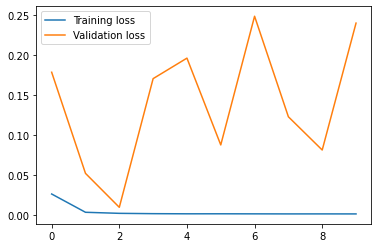

In [ ]:
plt.plot(his.history['loss'], label='Training loss')
plt.plot(his.history['val_loss'], label='Validation loss') 
plt.legend()
plt.show()


# ***Predict Model***

In [ ]:
def cnn_predict(img_path):

  img = image.load_img(img_path, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  y = finalmodel.predict(x)
  return alphabet[np.argmax(y)]

In [ ]:
def ASL_detect(img_path):
    plt.imshow(plt.imread(img_path))
    plt.show()
    print('that sing mean .....')
    
    print('using CNN .............' ,cnn_predict(img_path))

/content/a/A_test.jpg


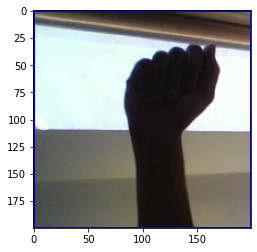

that sing mean .....
using CNN ............. A
/content/a/D_test.jpg


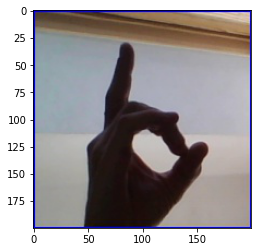

that sing mean .....
using CNN ............. D
/content/a/V_test.jpg


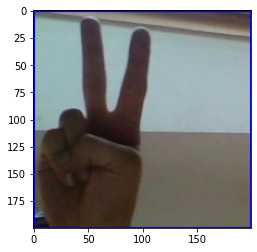

that sing mean .....
using CNN ............. W_OR_6
/content/a/P_test.jpg


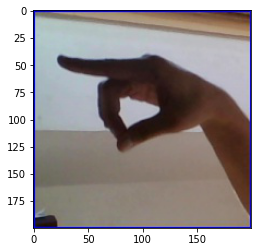

that sing mean .....
using CNN ............. P
/content/a/R_test.jpg


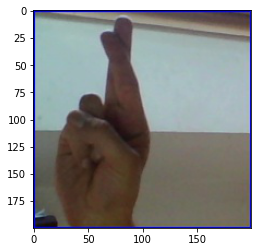

that sing mean .....
using CNN ............. R
/content/a/U_test.jpg


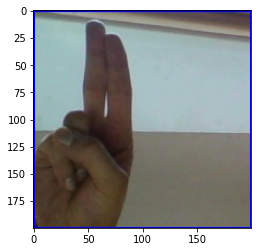

that sing mean .....
using CNN ............. U
/content/a/W_test.jpg


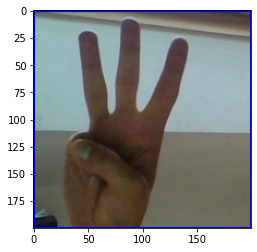

that sing mean .....
using CNN ............. W_OR_6
/content/a/H_test.jpg


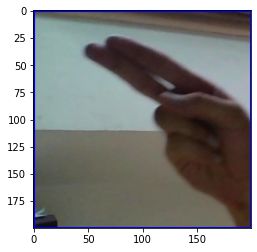

that sing mean .....
using CNN ............. H
/content/a/F_test.jpg


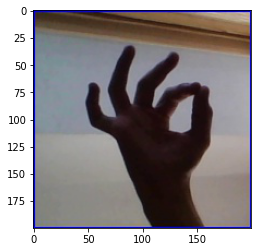

that sing mean .....
using CNN ............. F
/content/a/Y_test.jpg


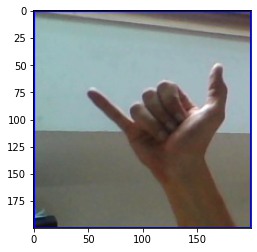

that sing mean .....
using CNN ............. Y
/content/a/E_test.jpg


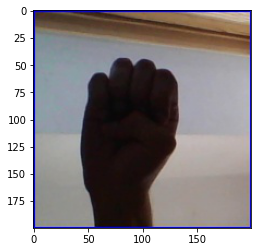

that sing mean .....
using CNN ............. E
/content/a/nothing_test.jpg


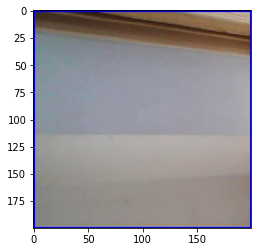

that sing mean .....
using CNN ............. nothing
/content/a/M_test.jpg


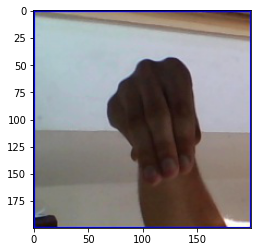

that sing mean .....
using CNN ............. M
/content/a/N_test.jpg


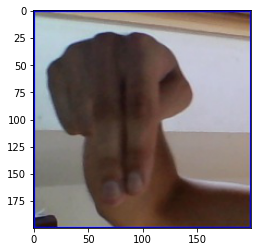

that sing mean .....
using CNN ............. N
/content/a/B_test.jpg


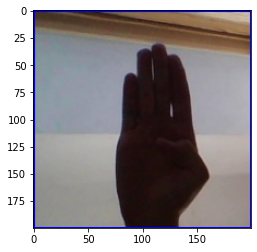

that sing mean .....
using CNN ............. B
/content/a/L_test.jpg


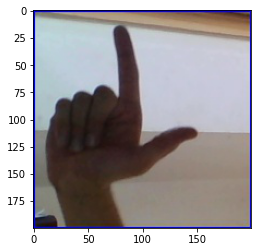

that sing mean .....
using CNN ............. L
/content/a/Q_test.jpg


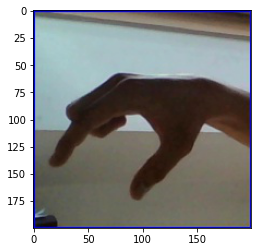

that sing mean .....
using CNN ............. Q
/content/a/O_test.jpg


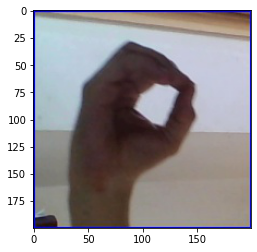

that sing mean .....
using CNN ............. O_OR_0
/content/a/S_test.jpg


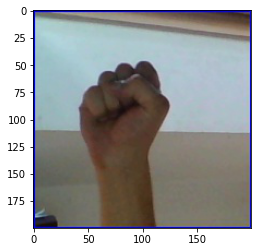

that sing mean .....
using CNN ............. S
/content/a/I_test.jpg


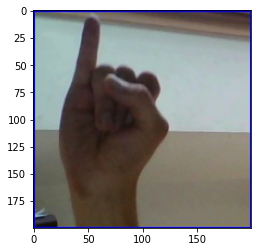

that sing mean .....
using CNN ............. I
/content/a/Z_test.jpg


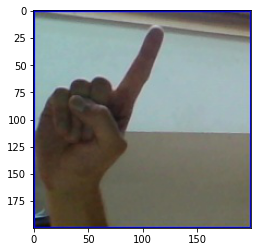

that sing mean .....
using CNN ............. Z
/content/a/C_test.jpg


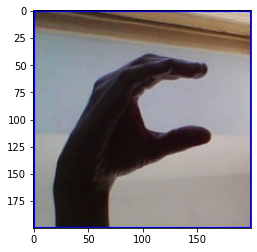

that sing mean .....
using CNN ............. C
/content/a/J_test.jpg


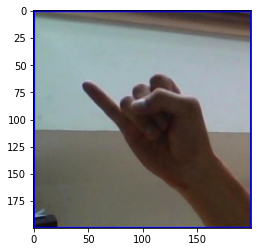

that sing mean .....
using CNN ............. J


In [ ]:
my_file=np.array(glob("/content/a/*"))

for i in my_file:
    print(i)
    ASL_detect(i)

/content/data/Brother.jpg


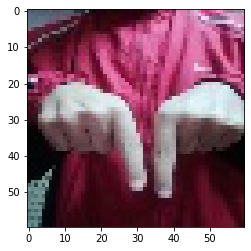

that sing mean .....
using CNN ............. Brother
/content/data/1.jpg


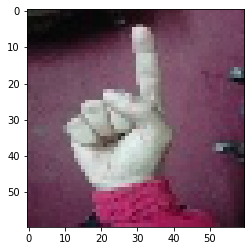

that sing mean .....
using CNN ............. 1
/content/data/NO.jpg


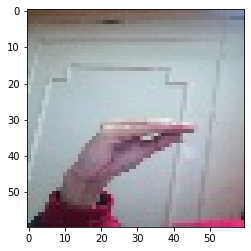

that sing mean .....
using CNN ............. No
/content/data/J.jpg


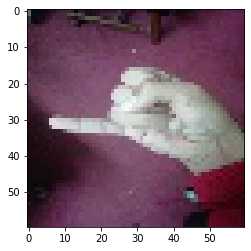

that sing mean .....
using CNN ............. J
/content/data/L.jpg


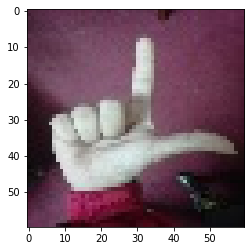

that sing mean .....
using CNN ............. L
/content/data/U.jpg


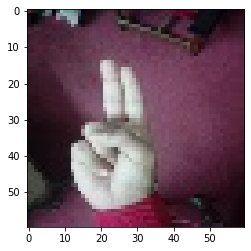

that sing mean .....
using CNN ............. 1
/content/data/love.jpg


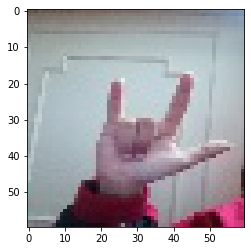

that sing mean .....
using CNN ............. Love
/content/data/Name.jpg


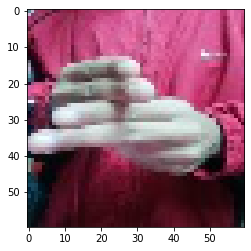

that sing mean .....
using CNN ............. Make
/content/data/More.jpg


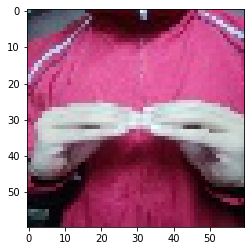

that sing mean .....
using CNN ............. More
/content/data/Y.jpg


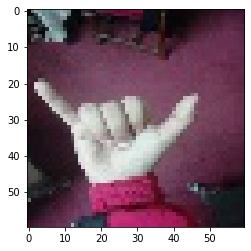

that sing mean .....
using CNN ............. Y
/content/data/Help.jpg


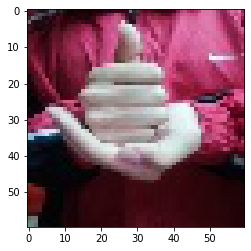

that sing mean .....
using CNN ............. Help
/content/data/N.jpg


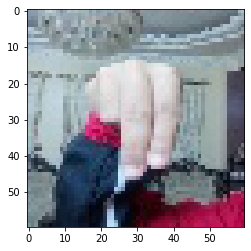

that sing mean .....
using CNN ............. N
/content/data/Z.jpg


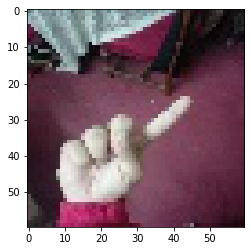

that sing mean .....
using CNN ............. Z
/content/data/Q.jpg


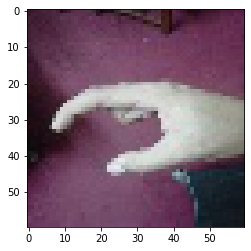

that sing mean .....
using CNN ............. Q
/content/data/Don't like.jpg


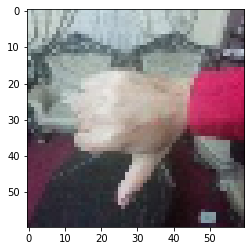

that sing mean .....
using CNN ............. Dont_like
/content/data/Frind.jpg


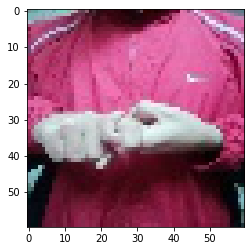

that sing mean .....
using CNN ............. Friend
/content/data/B.jpg


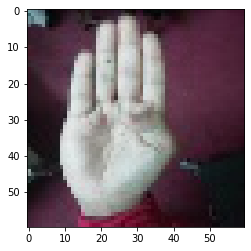

that sing mean .....
using CNN ............. B
/content/data/Yes.jpg


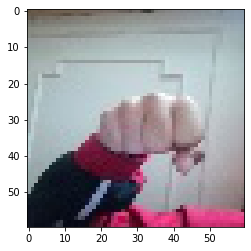

that sing mean .....
using CNN ............. Yes
/content/data/P.jpg


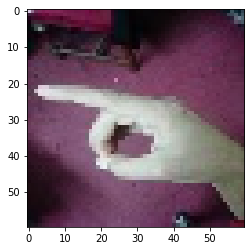

that sing mean .....
using CNN ............. P
/content/data/C.jpg


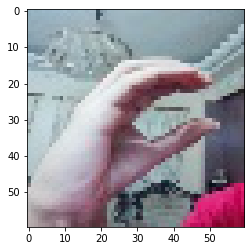

that sing mean .....
using CNN ............. C
/content/data/2.jpg


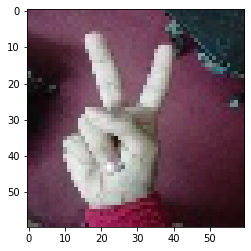

that sing mean .....
using CNN ............. V_OR_2
/content/data/Pay.jpg


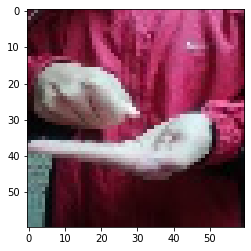

that sing mean .....
using CNN ............. 1
/content/data/F.jpg


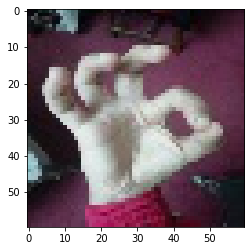

that sing mean .....
using CNN ............. 9
/content/data/stop.jpg


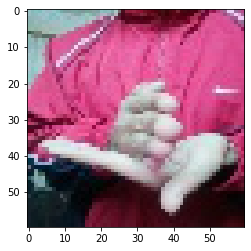

that sing mean .....
using CNN ............. Stop
/content/data/M.jpg


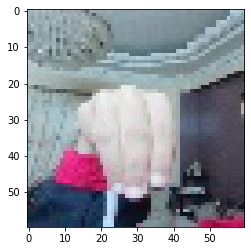

that sing mean .....
using CNN ............. M
/content/data/T.jpg


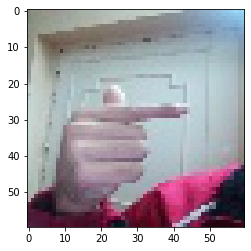

that sing mean .....
using CNN ............. T
/content/data/G.jpg


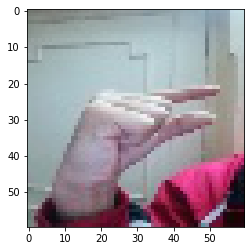

that sing mean .....
using CNN ............. G
/content/data/Make.jpg


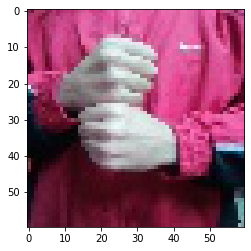

that sing mean .....
using CNN ............. Make
/content/data/Play.jpg


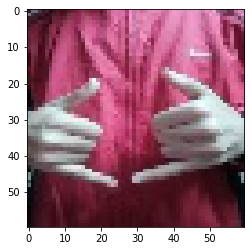

that sing mean .....
using CNN ............. Play
/content/data/like.jpg


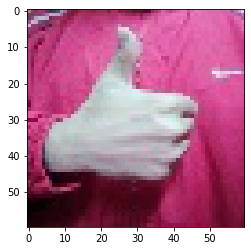

that sing mean .....
using CNN ............. Like
/content/data/7.jpg


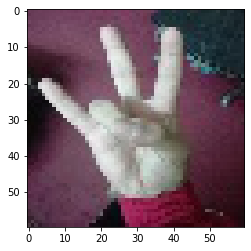

that sing mean .....
using CNN ............. 7
/content/data/8.jpg


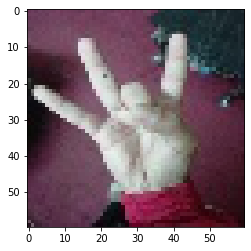

that sing mean .....
using CNN ............. 8
/content/data/K.jpg


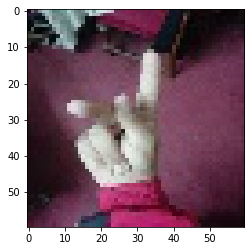

that sing mean .....
using CNN ............. 1
/content/data/5.jpg


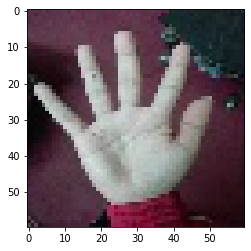

that sing mean .....
using CNN ............. 5
/content/data/9.jpg


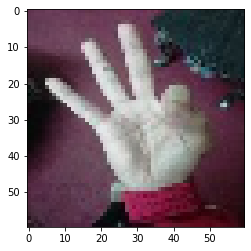

that sing mean .....
using CNN ............. 9
/content/data/3.jpg


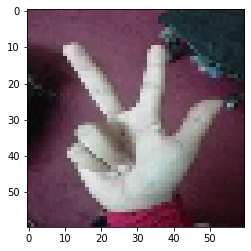

that sing mean .....
using CNN ............. 3
/content/data/S.jpg


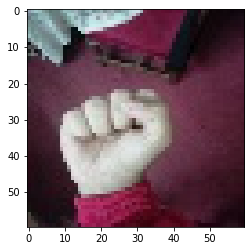

that sing mean .....
using CNN ............. S
/content/data/H.jpg


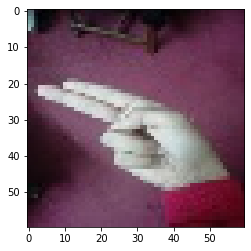

that sing mean .....
using CNN ............. H
/content/data/D.jpg


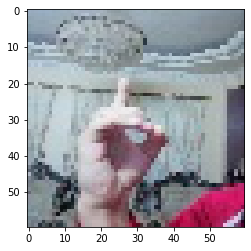

that sing mean .....
using CNN ............. D
/content/data/6.jpg


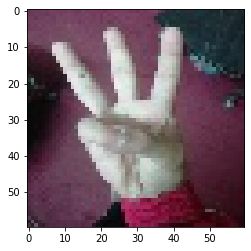

that sing mean .....
using CNN ............. W_OR_6
/content/data/4.jpg


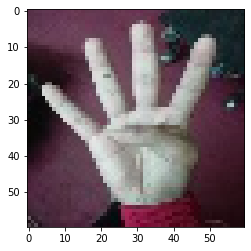

that sing mean .....
using CNN ............. 4
/content/data/X.jpg


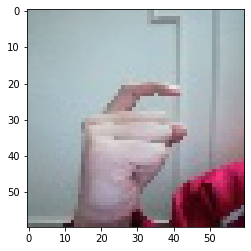

that sing mean .....
using CNN ............. X
/content/data/House.jpg


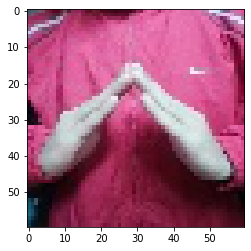

that sing mean .....
using CNN ............. House
/content/data/I.jpg


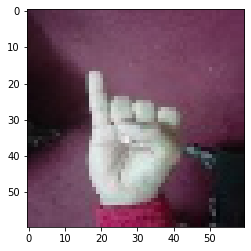

that sing mean .....
using CNN ............. I
/content/data/E.jpg


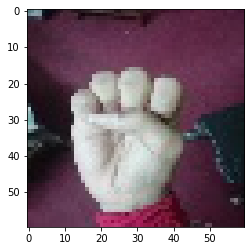

that sing mean .....
using CNN ............. E
/content/data/A.jpg


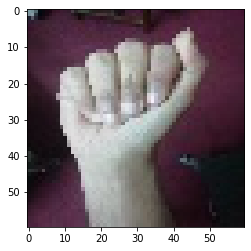

that sing mean .....
using CNN ............. A
/content/data/Baby.jpg


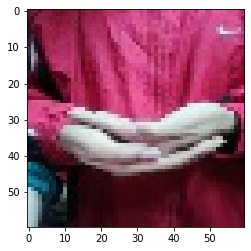

that sing mean .....
using CNN ............. Baby
/content/data/With.jpg


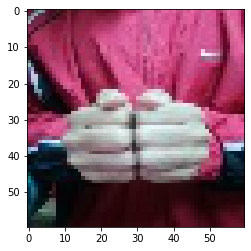

that sing mean .....
using CNN ............. With
/content/data/R.jpg


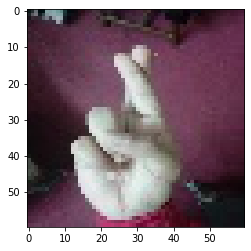

that sing mean .....
using CNN ............. 1


In [ ]:
my_file=np.array(glob("/content/data/*"))

for i in my_file:
    print(i)
    ASL_detect(i)

# ***Save Model***

In [ ]:
finalmodel.save('/content/model.h5')